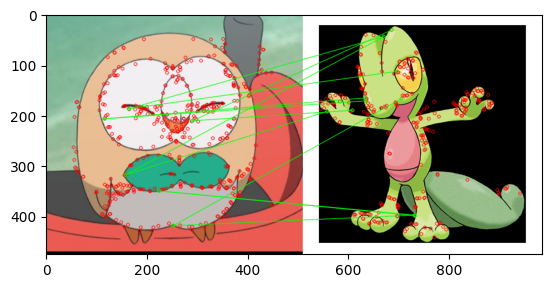

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

def pre_v1(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    eq_img = cv2.equalizeHist(gray_img)
    blur_img = cv2.medianBlur(eq_img, 9)
    return blur_img

def pre_v2(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    eq_img = cv2.equalizeHist(gray_img)
    blur_img = cv2.GaussianBlur(eq_img, (3, 3), 0)
    return blur_img

def find_best_match(pre_func, data_path, target_path):
    target_img = cv2.imread(target_path)
    target_img = cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB)
    target_gray = pre_func(target_img)

    akaze = cv2.AKAZE.create()
    target_keypoints, target_desc = akaze.detectAndCompute(target_gray, None)
    target_desc = np.float32(target_desc)

    index_params = dict(algorithm=1, tree=5)
    search_params = dict(check=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # flann = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)

    best_match = 0
    best_match_data = {}

    for img_path in os.listdir(data_path):
        img = cv2.imread(data_path + img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_gray = pre_func(img)

        img_keypoints, img_desc = akaze.detectAndCompute(img_gray, None)        
        img_desc = np.float32(img_desc)

        matches = flann.knnMatch(target_desc, img_desc, k=2)
        mask_matches = [[0, 0] for _ in range(len(matches))]

        curr_match = 0

        for i, (m, n) in enumerate(matches):
            if m.distance < 0.7 * n.distance:
                curr_match += 1
                mask_matches[i] = [1, 1]                
        
        if curr_match > best_match:
            best_match = curr_match
            best_match_data = {
                "img": img,
                "img_path": img_path,
                "matches": matches,
                "img_desc": img_desc,
                "best_match": best_match,
                "keypoints": img_keypoints,
                "matches_mask": mask_matches
            }

    result = cv2.drawMatchesKnn(
        target_img, target_keypoints,
        best_match_data["img"], best_match_data["keypoints"],
        best_match_data["matches"], None,
        matchColor=[0, 255, 0],
        singlePointColor=[255, 0, 0],
        matchesMask=best_match_data["matches_mask"]
    )

    plt.figure()
    plt.imshow(result)
    plt.show()

find_best_match(pre_v2, "./Images/Data/", "./Images/Object2.png")